In [122]:
# Ignore dumb warning through the iterations
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# General libraries
import numpy as np
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
import joblib

# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score

# Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC

LDA
QDA

In [123]:
aux = pd.read_csv('../data/clean_data.csv', index_col='Municipality')
aux[['culture_knowledge_of_catalan_speak', 'population_population_by_sex_total']].corr()

,culture_knowledge_of_catalan_speak,population_population_by_sex_total
culture_knowledge_of_catalan_speak,1.000000,-0.187062
population_population_by_sex_total,-0.187062,1.000000


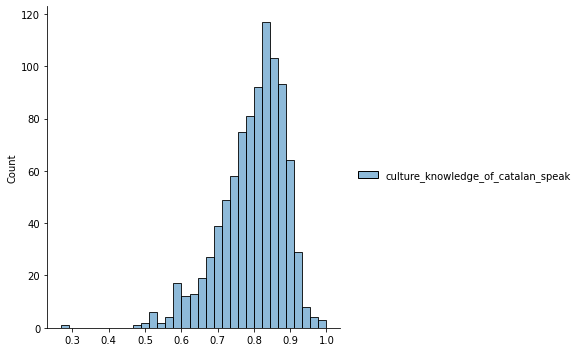

In [124]:
# Get data
df = pd.read_csv('../data/clean_data.csv', index_col='Municipality')
dg = pd.read_csv('../data/model_data.csv', index_col='Municipality')
# dg.head()

# Get proper label
labels = df.filter(like='catalan')
label = df.filter(like='catalan').filter(like='speak')
df = df.loc[:, ~df.columns.isin(labels.columns)]

data = label.join(dg, on='Municipality')
# data.head()

# Get trainin data and label
label = data['culture_knowledge_of_catalan_speak'].to_frame()
data = data.drop(['culture_knowledge_of_catalan_speak'], axis=1)

sns.displot(label)

label[:] = pd.qcut(label['culture_knowledge_of_catalan_speak'], q=4, labels=[0,1,2,3])
label[label['culture_knowledge_of_catalan_speak'] == 2] = 1
label[label['culture_knowledge_of_catalan_speak'] == 3] = 2

In [125]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, stratify=label, random_state=42)

Linear Discriminant Analysis

In [126]:
start_time = time.time()
model = LinearDiscriminantAnalysis()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = [
    {'solver': ['svd']},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [np.arange(0, 1, 0.01)]}
]

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6652096667787754
Best Hyperparameters: {'solver': 'svd'}
Time: 0.23299169540405273


In [127]:
joblib.dump(search, '../pickles/search_lda.pkl')

['../pickles/search_lda.pkl']

In [128]:
start_time = time.time()
model = QuadraticDiscriminantAnalysis()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'reg_param': np.arange(0, 1, 0.01)
}

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6610645701576462
Best Hyperparameters: {'reg_param': 0.91}
Time: 4.4155683517456055


In [129]:
joblib.dump(search, '../pickles/search_qda.pkl')

['../pickles/search_qda.pkl']

In [130]:
start_time = time.time()
model = GaussianNB()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'var_smoothing': [1e-9, 1e-7, 1e-3]
}

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6412616022017837
Best Hyperparameters: {'var_smoothing': 0.001}
Time: 0.2135024070739746


In [131]:
joblib.dump(search, '../pickles/search_gaus.pkl')

['../pickles/search_gaus.pkl']

Logistic Regression

In [132]:
from scipy.stats import loguniform

start_time = time.time()
model = LogisticRegression(random_state=42, max_iter=500)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = [
    {'solver': ['newton-cg'], 'penalty': ['l2'], 'C': loguniform(1e-1, 100), 'class_weight': [None, 'balanced']},
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': loguniform(1e-1, 100), 'class_weight': [None, 'balanced']},
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': loguniform(1e-1, 100), 'class_weight': [None, 'balanced']}
    # {'solver': ['saga'], 'penalty': ['elasticnet', 'l1', 'l2', 'none'], 'C': loguniform(1e-3, 100), 'class_weight': [None, 'balanced']}
]

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6714406385465467
Best Hyperparameters: {'C': 0.10325142852622374, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}
Time: 136.4034080505371


In [133]:
joblib.dump(search, '../pickles/search_lr.pkl')

['../pickles/search_lr.pkl']

In [134]:
# def plot_grid_results(grid):
#     import pandas as pd
    
#     data = pd.DataFrame(grid.cv_results_).filter(regex=r'mean_test_score|std_test_score|param_')
#     return data 

# df = plot_grid_results(search)
# df.head()

In [135]:
# sns.lineplot(x='param_C', y='mean_test_score', hue='param_penalty', data=df)

In [136]:
start_time = time.time()
model = SGDClassifier(random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'loss': ['log', 'hinge', 'perceptron'],
    'penalty': ['elasticnet', 'l2'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
    'class_weight': [None, 'Balanced']
}

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6663216971978735
Best Hyperparameters: {'penalty': 'elasticnet', 'loss': 'log', 'l1_ratio': 0.2, 'class_weight': None, 'alpha': 0.01}
Time: 34.313310384750366


In [137]:
joblib.dump(search, '../pickles/search_sgd.pkl')

['../pickles/search_sgd.pkl']

In [138]:
start_time = time.time()
model = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'n_neighbors': range(2, 30, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'kd_tree']
}

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6509785894398326
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 24, 'algorithm': 'auto'}
Time: 2.987490653991699


In [139]:
joblib.dump(search, '../pickles/search_knn.pkl')

['../pickles/search_knn.pkl']

In [140]:
start_time = time.time()
model = DecisionTreeClassifier(random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
}

search = RandomizedSearchCV(model, random_grid, n_iter=500, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.593880038555827
Best Hyperparameters: {'max_depth': 4, 'criterion': 'gini'}
Time: 4.30318021774292


In [141]:
joblib.dump(search, '../pickles/search_dt.pkl')

['../pickles/search_dt.pkl']

In [142]:
start_time = time.time()
model = RandomForestClassifier(oob_score=True, random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

search = RandomizedSearchCV(model, random_grid, n_iter=50, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6399660566235884
Best Hyperparameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
Time: 503.83829736709595


In [143]:
joblib.dump(search, '../pickles/search_rf.pkl')

['../pickles/search_rf.pkl']

In [145]:
start_time = time.time()
model = SVC(random_state=42, probability=True)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

random_grid = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'decision_function_shape': ['ovr', 'ovo']},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'decision_function_shape': ['ovr', 'ovo']},
    {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'decision_function_shape': ['ovr', 'ovo']}
]

search = RandomizedSearchCV(model, random_grid, n_iter=10, scoring='f1_weighted', n_jobs=-1, cv=cv, random_state=42)

result = search.fit(X_train, y_train.values.ravel())
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

elapsed_time = time.time() - start_time
print('Time:', elapsed_time)

Best Score: 0.6715789998536166
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'decision_function_shape': 'ovo', 'class_weight': None, 'C': 10}
Time: 10.077317714691162


In [153]:
joblib.dump(search, '../pickles/search_svm.pkl')

['../pickles/search_svm.pkl']

---

In [154]:
import joblib

search_lda = joblib.load('../pickles/search_lda.pkl')
search_qda = joblib.load('../pickles/search_qda.pkl')
search_gaus = joblib.load('../pickles/search_gaus.pkl')
search_lr = joblib.load('../pickles/search_lr.pkl')
search_sgd = joblib.load('../pickles/search_sgd.pkl')
search_knn = joblib.load('../pickles/search_knn.pkl')
search_dt = joblib.load('../pickles/search_dt.pkl')
search_rf = joblib.load('../pickles/search_rf.pkl')
search_svm = joblib.load('../pickles/search_svm.pkl')

In [160]:
best_lda = LinearDiscriminantAnalysis(**search_lda.best_params_)
best_qda = QuadraticDiscriminantAnalysis(**search_qda.best_params_)
best_gaus = GaussianNB(**search_gaus.best_params_)
best_lr = LogisticRegression(**search_lr.best_params_, random_state=42)
best_sgd = SGDClassifier(**search_sgd.best_params_, random_state=42)
best_knn = KNeighborsClassifier(**search_knn.best_params_)
best_dt = DecisionTreeClassifier(**search_dt.best_params_, random_state=42)
best_rf = RandomForestClassifier(**search_rf.best_params_, random_state=42)
best_svm = SVC(**search_svm.best_params_, random_state=42, probability=True)

In [ ]:
# best_lda.fit(X_train, y_train.values.ravel())
# best_qda.fit(X_train, y_train.values.ravel())
# best_gaus.fit(X_train, y_train.values.ravel())
# best_lr.fit(X_train, y_train.values.ravel())
# best_sgd.fit(X_train, y_train.values.ravel())
# best_knn.fit(X_train, y_train.values.ravel())
# best_dt.fit(X_train, y_train.values.ravel())
# best_rf.fit(X_train, y_train.values.ravel())
# best_svm.fit(X_train, y_train.values.ravel())

SVC(C=100, gamma=0.001, kernel='sigmoid', random_state=42)

In [173]:
voting_hard = VotingClassifier([('lda', best_lda), 
                                ('qda', best_qda),
                                ('gaus', best_gaus),
                                ('lr', best_lr),
                                ('sgd', best_sgd),
                                ('knn', best_knn),
                                ('dt', best_dt),
                                ('rf', best_rf),
                                ('svm', best_svm),
])

In [162]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

scores = cross_val_score(voting_hard, X_train, y_train.values.ravel(), cv=10, n_jobs=-1, scoring='f1_weighted')
scores.mean()

0.6710325713221884

In [163]:
voting_soft = VotingClassifier([('lda', best_lda), 
                                ('qda', best_lda),
                                ('gaus', best_gaus),
                                ('lr', best_lr),
                                ('sgd', best_sgd),
                                ('knn', best_knn),
                                ('dt', best_dt),
                                ('rf', best_rf),
                                ('svm', best_svm)
], voting='soft')

In [164]:
scores = cross_val_score(voting_soft, X_train, y_train.values.ravel(), cv=10, n_jobs=-1, scoring='f1_weighted')
scores.mean()

0.6574083254388418

In [170]:
voting_soft.get_params()['voting']

'soft'

In [180]:
from sklearn.model_selection import cross_validate

results = pd.DataFrame(columns=['Accuracy', 'F1-score (Micro)', 'F1-score (Macro)', 'F1-score (Weighted)'])

models = [best_lda, best_qda, best_gaus, best_lr, best_sgd, best_knn, best_dt, best_rf, best_svm, voting_hard, voting_soft]

def compute_results(models=models):
    for model in models:
        name = type(model).__name__
        name = ''.join([c for c in name if c.isupper()])
        if name == 'VC':
            name = name + model.get_params()['voting'][0]
            
        scores = cross_validate(model, X_train, y_train.values.ravel(), cv=10, scoring=('accuracy', 'f1_micro', 'f1_macro', 'f1_weighted'))
        results.loc[name, 'Accuracy'] = scores['test_accuracy'].mean()
        results.loc[name, 'F1-score (Micro)'] = scores['test_f1_micro'].mean()
        results.loc[name, 'F1-score (Macro)'] = scores['test_f1_macro'].mean()
        results.loc[name, 'F1-score (Weighted)'] = scores['test_f1_weighted'].mean()
        
    return results

results = compute_results()

In [181]:
results.sort_values(by='F1-score (Weighted)')

,Accuracy,F1-score (Micro),F1-score (Macro),F1-score (Weighted)
DTC,0.609968,0.609968,0.536517,0.575517
GNB,0.640931,0.640931,0.620046,0.638207
KNC,0.676626,0.676626,0.616758,0.646893
RFC,0.660338,0.660338,0.625195,0.647224
LDA,0.658752,0.658752,0.637555,0.652669
QDA,0.655368,0.655368,0.659447,0.653933
VCs,0.666869,0.666869,0.639412,0.657408
LR,0.663538,0.663538,0.648386,0.659541
SGDC,0.668403,0.668403,0.646441,0.661013
VCh,0.678265,0.678265,0.655551,0.671033


In [210]:
voting_best = VotingClassifier([('sgd', best_sgd),
                                ('lr', best_lr),
                                ('qda', best_qda),
                                ('lda', best_lda),
                                ('knn', best_knn)
], voting='soft')

scores = cross_validate(voting_best, X_train, y_train.values.ravel(), cv=10, scoring=('accuracy', 'f1_micro', 'f1_macro', 'f1_weighted'))
results.loc['VCb', 'Accuracy'] = scores['test_accuracy'].mean()
results.loc['VCb', 'F1-score (Micro)'] = scores['test_f1_micro'].mean()
results.loc['VCb', 'F1-score (Macro)'] = scores['test_f1_macro'].mean()
results.loc['VCb', 'F1-score (Weighted)'] = scores['test_f1_weighted'].mean()

In [213]:
results.sort_values(by='F1-score (Weighted)')

,Accuracy,F1-score (Micro),F1-score (Macro),F1-score (Weighted)
DTC,0.609968,0.609968,0.536517,0.575517
GNB,0.640931,0.640931,0.620046,0.638207
KNC,0.676626,0.676626,0.616758,0.646893
RFC,0.660338,0.660338,0.625195,0.647224
LDA,0.658752,0.658752,0.637555,0.652669
QDA,0.655368,0.655368,0.659447,0.653933
VCs,0.666869,0.666869,0.639412,0.657408
LR,0.663538,0.663538,0.648386,0.659541
SGDC,0.668403,0.668403,0.646441,0.661013
VCh,0.678265,0.678265,0.655551,0.671033


In [ ]:
stacky = StackingClassifier(
    estimators=[('svm', best_svm), 
                ('sgd', best_sgd),
                ('lr', best_lr),
                ('rf', best_rf),
                                
],
    final_estimator=GradientBoostingClassifier())

scores = cross_val_score(stacky, X_train, y_train.values.ravel(), cv=10, n_jobs=-1, scoring='f1_weighted')
print(scores)
scores.mean()

[0.64534668 0.57600603 0.59635869 0.58405505 0.60876758 0.67035697
 0.65677743 0.6667797  0.62427846 0.63503213]


0.6263758713435614